In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

data=pd.read_csv("/content/data_banknote_authentication.txt")
data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Checking for null and '?' values

In [3]:
data.isna().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [4]:
(data=='?').sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

Checking for duplicate rows

In [5]:
data.index[data.duplicated()]

Int64Index([ 47, 139, 190, 195, 226, 268, 284, 300, 315, 320, 345, 351, 352,
            404, 427, 436, 476, 498, 604, 615, 657, 691, 716, 727],
           dtype='int64')

In [6]:
data=data.drop_duplicates()

In [7]:
data.index[data.duplicated()]

Int64Index([], dtype='int64')

Checking the number of classes and their count

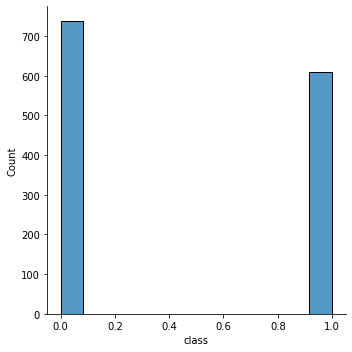

In [8]:
sns.displot(data,x="class")

Checking outliers

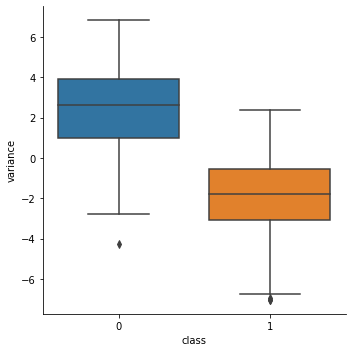

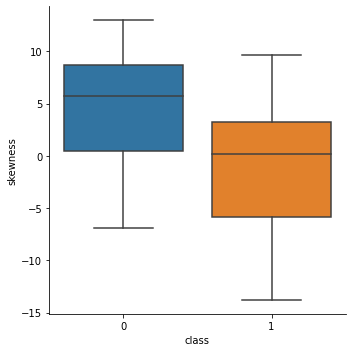

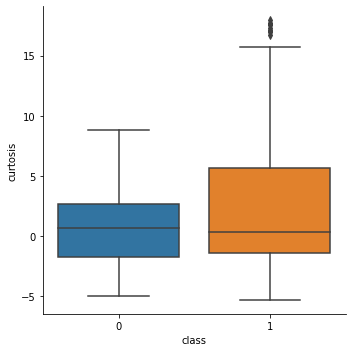

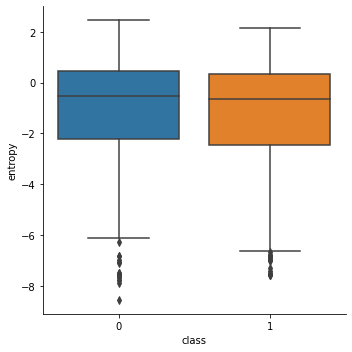

In [9]:
for c in list(data.columns)[:4]:
  sns.catplot(kind="box",x="class",y=c,data=data)

Removing outliers

In [10]:
def manageOutliers(dt,c):
  lq0=dt[c].loc[(dt['class']==0)].quantile(0.25)
  lq1=dt[c].loc[(dt['class']==1)].quantile(0.25)
  uq0=dt[c].loc[(dt['class']==0)].quantile(0.75)
  uq1=dt[c].loc[(dt['class']==1)].quantile(0.75)
  uw0=uq0+1.5*(uq0-lq0)
  lw0=lq0-1.5*(uq0-lq0)
  uw1=uq1+1.5*(uq1-lq1)
  lw1=lq1-1.5*(uq1-lq1)
  dt.drop(axis="rows",labels=dt.index[(dt["class"]==0) & ((dt[c]>uw0) | (dt[c]<lw0))],inplace=True)
  dt.drop(axis="rows",labels=dt.index[(dt["class"]==1) & ((dt[c]>uw1) | (dt[c]<lw1))],inplace=True)
  return dt

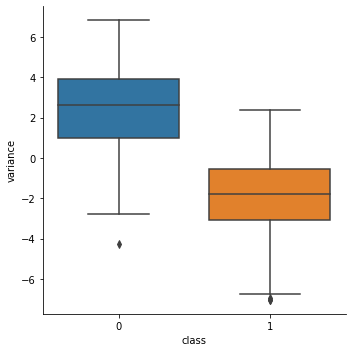

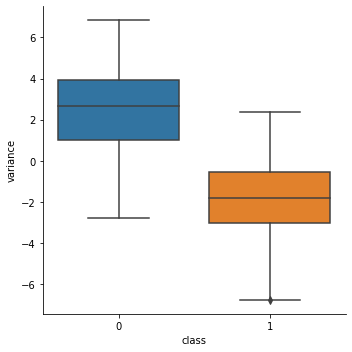

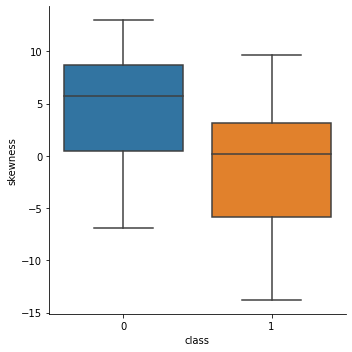

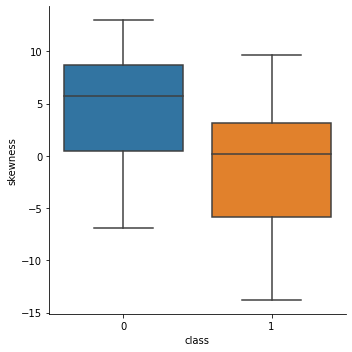

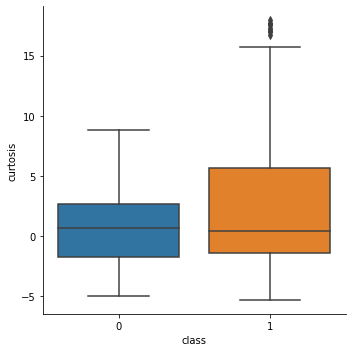

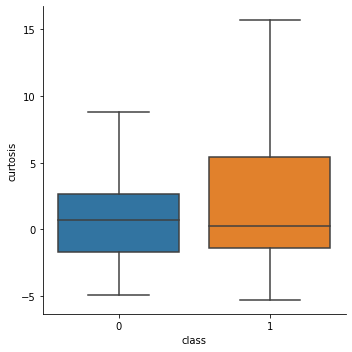

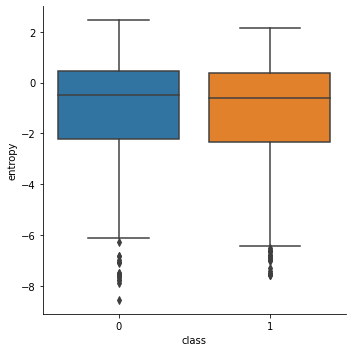

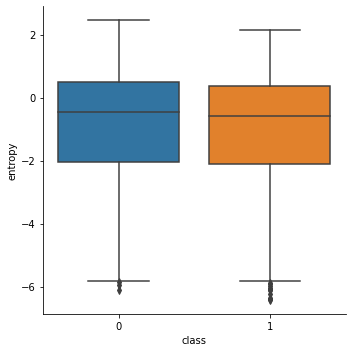

In [11]:
for c in list(data.columns)[:4]:
  sns.catplot(kind="box",x="class",y=c,data=data)
  data=manageOutliers(data,c)
  sns.catplot(kind="box",x="class",y=c,data=data)

Distribution of data across columns

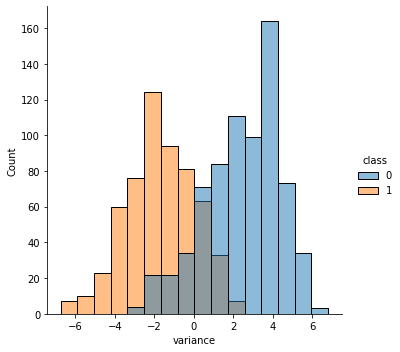

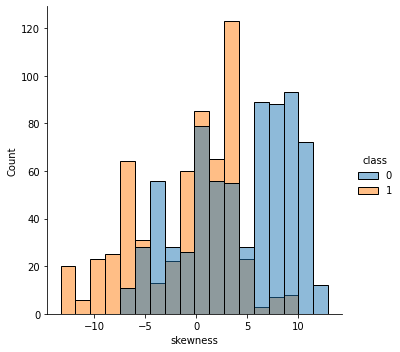

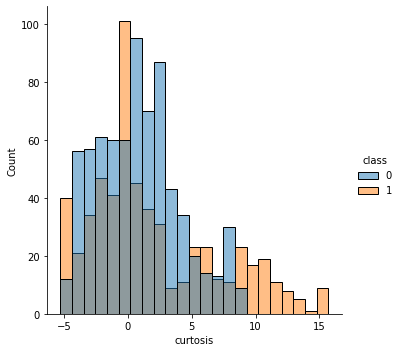

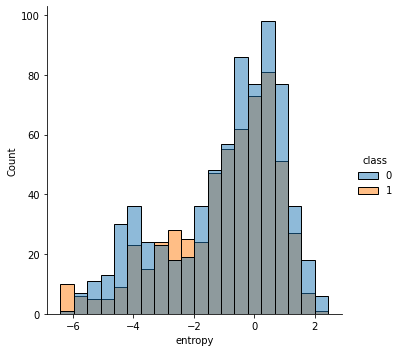

In [12]:
for c in list(data.columns)[:4]:
  sns.displot(data,x=c,hue=data["class"])

Looks like gaussian distribution

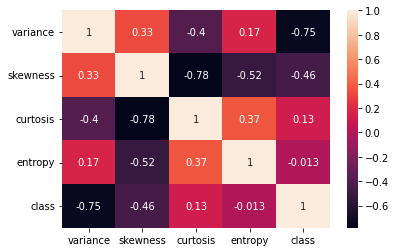

In [13]:
sns.heatmap(data.corr(),annot=True)

We can see that entropy has very less correlation with the class. So if we want we can drop that column. But I will keep it for now and see the results.

In [14]:
class Normalizer:
  def __init__(self,mean,stdev):
    self.mean=mean
    self.stdev=stdev
  def normalize(self,t):
    return (t-self.mean)/(self.stdev)

Normalizing the data

In [15]:
for c in list(data.columns)[:4]:
  normalizer=Normalizer(data[c].mean(),data[c].std())
  data[c]=data[c].apply(normalizer.normalize)

Train-test split(70-30)

In [16]:
train_set=data.sample(frac=0.7, replace=False)
test_set=data.drop(train_set.index)

train_x=train_set.drop(columns=["class"])
train_y=train_set["class"]

test_x=test_set.drop(columns=["class"])
test_y=test_set["class"]

train_x=train_x.to_numpy()
train_y=train_y.to_numpy()
test_x=test_x.to_numpy()
test_y=test_y.to_numpy()

Adding the column for the constant term w0 in the X matrix

In [17]:
train_x_final=np.insert(train_x,0,1,axis=1)
test_x_final=np.insert(test_x,0,1,axis=1)

Now we build the models

#1. Logistic Regression

In [18]:
def sigmoid(w,x):
  t=((w.T)@x)
  sig=1/(1+np.exp(-t))
  return sig

In [19]:
def gradientDescent(w,x,y,n,alpha):
  for i in range(n):
    s=[0]*len(x)
    for j in range(len(x)):
      s[j]=(sigmoid(w,x[j]))
    e=y-s
    delJ=(x.T@(-e))
    w=w-alpha*delJ
  return w

##Multivariate

Getting the weights for multivariate logistic regression

In [20]:
W=gradientDescent(np.array([1]*len(train_x_final[0])),train_x_final,train_y,4000,0.1)

In [21]:
def predict(w,x):
  yp=[]
  for i in range(len(x)):
    yp.append(sigmoid(w,x[i]))
  return yp

def findAccuracy(yp,y):
  correct=0
  wrong=0
  tp=0
  fp=0
  tn=0
  fn=0
  for i in range(len(yp)):
    if(round(yp[i])==y[i]):
      correct+=1
      if(y[i]==1):
        tp+=1
      else:
        tn+=1
    else:
      wrong+=1
      if(y[i]==1):
        fn+=1
      else:
        fp+=1
  percentageAccuracy=correct*100/len(yp)
  #pr=tp/(tp+fp)
  #rec=tp/(tp+fn)
  f1=tp/(tp+(fp+fn)/2)
  return correct, wrong, percentageAccuracy, [[tp,fn],[fp,tn]], f1

In [22]:
findAccuracy(predict(W,train_x_final),train_y)

(906, 3, 99.66996699669967, [[419, 1], [2, 487]], 0.9964328180737217)

In [23]:
findAccuracy(predict(W,test_x_final),test_y)

(387, 3, 99.23076923076923, [[156, 2], [1, 231]], 0.9904761904761905)

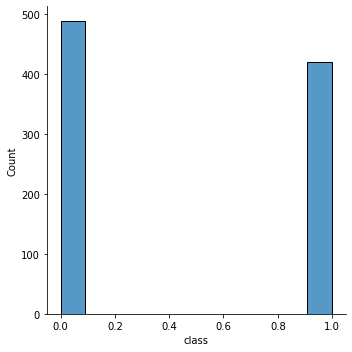

In [24]:
sns.displot(train_set,x="class")

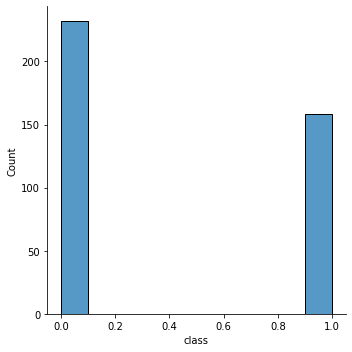

In [25]:
sns.displot(test_set,x="class")

#2. Naive Bayes
Univariate

We will split the training data according to the classes and get mean and variance for each column wrt each class

In [26]:
#Calculating the prior probabilities according to the training data given
p1=np.count_nonzero(train_y)/len(train_y)
p0=1-p1

# to find mean and variance of each class, we need to divide the dataset appropriately first
train_x0=[]
train_x1=[]
for i in range(len(train_x)):
  if(train_y[i]==0):
    train_x0.append(train_x[i])
  else:
    train_x1.append(train_x[i])
train_x0=np.array(train_x0)
train_x1=np.array(train_x1)

# mean and variance (of each column)
m0=np.mean(train_x0,axis=0,dtype=np.float64)
m1=np.mean(train_x1,axis=0,dtype=np.float64)
v0=np.var(train_x0,axis=0,dtype=np.float64)
v1=np.var(train_x1,axis=0,dtype=np.float64)

def N(m,v,x):
  return math.exp(-((x-m)**2)/(2*v))/(math.sqrt(2*math.pi*v))

In [27]:
def predictNB(m0,v0,m1,v1,x):
  gp0=N(m0,v0,x)
  gp1=N(m1,v1,x)
  if(gp0*p0>gp1*p1):
    return 0
  else:
    return 1

colToIndex={
    "variance":0,
    "skewness":1,
    "curtosis":2,
    "entropy":3
}

def testModel(feature,x,y):
  ftind=colToIndex[feature]
  correct=wrong=0
  tp=0
  fp=0
  tn=0
  fn=0
  for i in range(len(x)):
    ypi=predictNB(m0[ftind],v0[ftind],m1[ftind],v1[ftind],x[i][ftind])
    if(ypi==y[i]):
      correct+=1
      if(y[i]==1):
        tp+=1
      else:
        tn+=1
    else:
      wrong+=1
      if(y[i]==1):
        fn+=1
      else:
        fp+=1
  #pr=tp/(tp+fp)
  #rec=tp/(tp+fn)
  f1=tp/(tp+(fp+fn)/2)
  #returns correct guesses, wrong guesses, acurracy %, confusion matrix, and f1 score
  return correct,wrong,correct*100/len(y), [[tp,fn],[fp,tn]], f1


In [28]:
from scipy.stats import norm
def plotGaussian(m0,s0,m1,s1,title):
  x0=np.linspace(m0-3*s0,m0+3*s0,1000)
  x1=np.linspace(m1-3*s1,m1+3*s1,1000)
  plt.plot(x0,norm.pdf(x0,m0,s0))
  plt.plot(x0,norm.pdf(x1,m1,s1))
  plt.title(title)
  plt.xlabel("x")
  plt.ylabel("p(x)")
  plt.legend(['0','1'])

We will test using every column/featue one by one

I can choose to just do this for a few columns/features with high correlation with output, but lets try to build a model with each one and see the if the correlation trend follows in the performances.

##Variance

In [29]:
testModel("variance",train_x,train_y)

(787, 122, 86.57865786578658, [[357, 63], [59, 430]], 0.854066985645933)

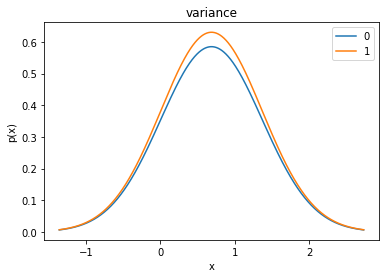

In [31]:
plotGaussian(m0[0],math.sqrt(v0[0]),m1[0],math.sqrt(v1[0]),"variance")

In [32]:
testModel("variance",test_x,test_y)

(336, 54, 86.15384615384616, [[141, 17], [37, 195]], 0.8392857142857143)

##Skewness

In [33]:
testModel("skewness",train_x,train_y)

(595, 314, 65.45654565456546, [[236, 184], [130, 359]], 0.6005089058524173)

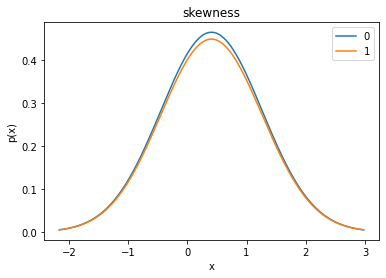

In [34]:
plotGaussian(m0[1],math.sqrt(v0[1]),m1[1],math.sqrt(v1[1]),"skewness")

In [35]:
testModel("skewness",test_x,test_y)

(255, 135, 65.38461538461539, [[91, 67], [68, 164]], 0.5741324921135647)

##Curtosis

In [36]:
testModel("curtosis",train_x,train_y)

(562, 347, 61.826182618261825, [[131, 289], [58, 431]], 0.4302134646962233)

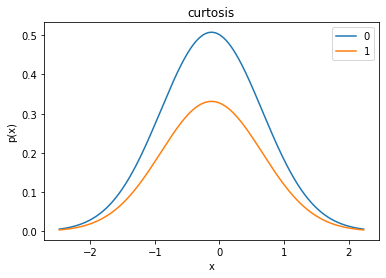

In [37]:
plotGaussian(m0[2],math.sqrt(v0[2]),m1[2],math.sqrt(v1[2]),"curtosis")

In [38]:
testModel("curtosis",test_x,test_y)

(253, 137, 64.87179487179488, [[49, 109], [28, 204]], 0.41702127659574467)

##Entropy

In [39]:
testModel("entropy",train_x,train_y)

(489, 420, 53.79537953795379, [[0, 420], [0, 489]], 0.0)

As we saw earlier, entropy had very less correlation with class, it is now evident with the poor perfomance of our model.

Our model only predicts 0 here.

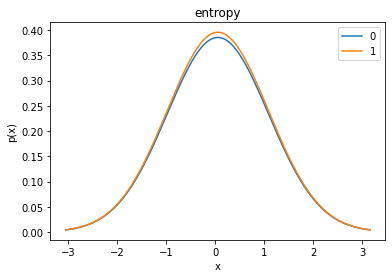

In [40]:
plotGaussian(m0[3],math.sqrt(v0[3]),m1[3],math.sqrt(v1[3]),"entropy")

In [41]:
testModel("entropy",test_x,test_y)

(232, 158, 59.48717948717949, [[0, 158], [0, 232]], 0.0)

So its clear that with decreasing correlation with output, model performance decreases.

Multivariate Gaussian

I will not implement this but try to come with a few combinations of features that could give good results with multivariate gaussian.

We try to have the features as mutually independent as possible

So we should have those features together that have less correlation among themselves.

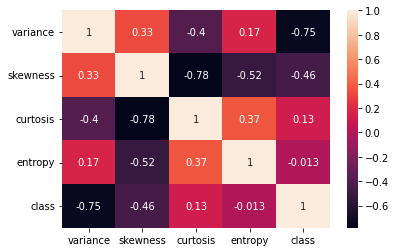

In [42]:
sns.heatmap(data.corr(),annot=True)

So some good choices will be(for two features lets say):
* variance and entropy
* variance and skewness (would be best because corr with output is high)
* curtosis and entropy <br>
etc. <br>
Choosing skewness and curtosis would be a bad idea. <br>
For 3 features:
* variance, entropy and curtosis
* variance, skewness and entropy

#3. Univariate Logistic regression

Getting the individual feature matrices

In [43]:
train_x1=np.array([train_x_final[:,0], train_x_final[:,1]]).T
train_x2=np.array([train_x_final[:,0], train_x_final[:,2]]).T
train_x3=np.array([train_x_final[:,0], train_x_final[:,3]]).T
train_x4=np.array([train_x_final[:,0], train_x_final[:,4]]).T

test_x1=np.array([test_x_final[:,0], test_x_final[:,1]]).T
test_x2=np.array([test_x_final[:,0], test_x_final[:,2]]).T
test_x3=np.array([test_x_final[:,0], test_x_final[:,3]]).T
test_x4=np.array([test_x_final[:,0], test_x_final[:,4]]).T

Variance

In [44]:
Wgd=gradientDescent(np.array([1]*2),train_x1,train_y,4000,0.1)
findAccuracy(predict(Wgd,train_x1),train_y)

(784, 125, 86.24862486248625, [[353, 67], [58, 431]], 0.8495788206979543)

In [45]:
findAccuracy(predict(Wgd,test_x1),test_y)

(335, 55, 85.8974358974359, [[139, 19], [36, 196]], 0.8348348348348348)

Skewness

In [46]:
Wgd=gradientDescent(np.array([1]*2),train_x2,train_y,4000,0.1)
findAccuracy(predict(Wgd,train_x2),train_y)

(314, 595, 34.54345434543454, [[98, 322], [273, 216]], 0.24778761061946902)

In [47]:
findAccuracy(predict(Wgd,test_x2),test_y)

(126, 264, 32.30769230769231, [[33, 125], [139, 93]], 0.2)

Curtosis

In [48]:
Wgd=gradientDescent(np.array([1]*2),train_x3,train_y,4000,0.1)
findAccuracy(predict(Wgd,train_x3),train_y)

(489, 420, 53.79537953795379, [[0, 420], [0, 489]], 0.0)

In [49]:
findAccuracy(predict(Wgd,test_x3),test_y)

(232, 158, 59.48717948717949, [[0, 158], [0, 232]], 0.0)

Entropy

In [50]:
Wgd=gradientDescent(np.array([1]*2),train_x4,train_y,4000,0.1)
findAccuracy(predict(Wgd,train_x4),train_y)

(489, 420, 53.79537953795379, [[0, 420], [0, 489]], 0.0)

In [51]:
findAccuracy(predict(Wgd,test_x4),test_y)

(232, 158, 59.48717948717949, [[0, 158], [0, 232]], 0.0)

Very low f1 score shows how bad this model is.

We can see that with lesser correlation with output, our model for that column/feature performs more and more poorly.